In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch, os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [2]:
class MnistModule(nn.Module):
    def __init__(self, in_, out_):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.f1 = nn.Linear(4 * 4 * 20, 100)
        self.out_layer = nn.Linear(100, out_)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = x.view(-1, 4 * 4 * 20)
        x = F.relu(self.f1(x))
        x = self.out_layer(x)
        return x


In [3]:
class MnistDataset(Dataset):
    def __init__(self, X_data, y_data) -> None:
        super().__init__()
        X_data = X_data if isinstance(X_data, np.ndarray) else X_data.values
        y_data = y_data if isinstance(y_data, np.ndarray) else y_data.values
        if X_data.dtype != np.float32:
            X_data = X_data.astype(np.float32)
        if y_data.dtype != np.int64:
            y_data = y_data.astype(np.int64)
        self.image = torch.FloatTensor(X_data)
        self.label = torch.LongTensor(y_data)

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.image[idx], self.label[idx]

    def getInOut(self):
        return self.image.shape[1], len(torch.unique(self.label))


In [4]:
train_file = "../../data/text/train.csv"
test_file = "../../data/text/t10k.csv"
train_np = np.loadtxt(train_file, delimiter=",", encoding="utf-8")
test_np = np.loadtxt(test_file, delimiter=",", encoding="utf-8")


In [5]:
train_np.shape, train_np.ndim, test_np.shape, test_np.ndim


((10001, 785), 2, (1001, 785), 2)

In [6]:
X_train = (train_np[:, 1:] / 255.0).astype(np.float32)
y_train = train_np[:, 0].astype(np.int64)


In [7]:
X_train = X_train.reshape(-1, 1, 28, 28)
X_train.shape


(10001, 1, 28, 28)

In [8]:
X_test = (test_np[:, 1:] / 255.0).astype(np.float32)
y_test = test_np[:, 0].astype(np.int64)


In [9]:
X_test = X_test.reshape(-1, 1, 28, 28)
X_test.shape


(1001, 1, 28, 28)

In [10]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print("DEVICE :", DEVICE)


DEVICE : cpu


In [11]:
BATCH_SIZE = 32
trainDS = MnistDataset(X_train, y_train)
testDS = MnistDataset(X_test, y_test)
trainDL = DataLoader(dataset=trainDS, batch_size=BATCH_SIZE, drop_last=True)
testDL = DataLoader(dataset=testDS, batch_size=BATCH_SIZE, drop_last=True)


In [12]:
len(trainDL.dataset)


10001

In [13]:
for image, label in trainDL:
    print("image:", image.size(), "type:", image.type())
    print("label:", label.size(), "type:", label.type())
    break


image: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
label: torch.Size([32]) type: torch.LongTensor


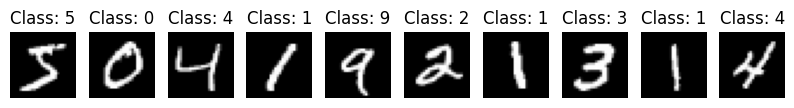

In [14]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis("off")
    plt.imshow(np.transpose(image[i], (1, 2, 0)), cmap="gray")
    plt.title("Class: " + str(label[i].item()))


In [15]:
EPOCHS = 50
IN, OUT = trainDS.getInOut()
MODEL = MnistModule(IN, OUT).to(DEVICE)
OPTIMIZER = optim.Adam(MODEL.parameters())
LOSS_FN = nn.CrossEntropyLoss()

print(MODEL)


MnistModule(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (f1): Linear(in_features=320, out_features=100, bias=True)
  (out_layer): Linear(in_features=100, out_features=10, bias=True)
)


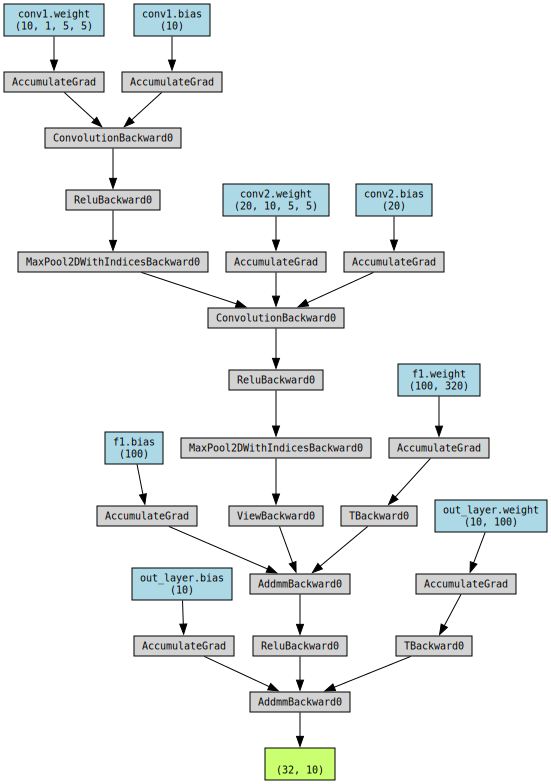

In [16]:
from torchviz import make_dot

make_dot(MODEL(image), params=dict(MODEL.named_parameters()))


In [17]:
def learning(epoch, model, loader, optimizer, mode="train", log_interval=200):
    if mode == "train":
        model.train()
        is_train = True
    elif mode == "test":
        model.eval()
        is_train = False
    else:
        raise ValueError("Invalid mode:", mode)

    loss_value = 0
    correct = 0
    with torch.set_grad_enabled(is_train):
        for batch_idx, (image, label) in enumerate(loader):
            image = image.to(DEVICE)
            label = label.to(DEVICE)

            output = model(image)
            loss = LOSS_FN(output, label)
            loss_value += loss.item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if batch_idx % log_interval == 0:
                    print(
                        f"Train Epoch: {epoch} [{batch_idx}]\tTrain Loss: {loss.item():.6f}"
                    )

    loss_value /= len(loader.dataset)
    accuracy = 100.0 * correct / len(loader.dataset)
    return loss_value, accuracy


In [18]:
pre_test_loss = 100
count = 0
for epoch in range(1, EPOCHS + 1):

    learning(epoch, MODEL, trainDL, OPTIMIZER, mode="train", log_interval=100)
    test_loss, test_accuracy = learning(epoch, MODEL, testDL, OPTIMIZER, mode="test")

    print(
        f"\n[EPOCH: {epoch}], \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} % \n"
    )

    if pre_test_loss > test_loss:
        pre_test_loss = test_loss
        count = 0
    else:
        count += 1
        if count == 5:
            break


Train Epoch: 1 [0]	Train Loss: 2.307832
Train Epoch: 1 [100]	Train Loss: 0.583382
Train Epoch: 1 [200]	Train Loss: 0.328157
Train Epoch: 1 [300]	Train Loss: 0.204086

[EPOCH: 1], 	Test Loss: 0.0090, 	Test Accuracy: 89.81 % 

Train Epoch: 2 [0]	Train Loss: 0.346538
Train Epoch: 2 [100]	Train Loss: 0.234627
Train Epoch: 2 [200]	Train Loss: 0.116806
Train Epoch: 2 [300]	Train Loss: 0.119979

[EPOCH: 2], 	Test Loss: 0.0067, 	Test Accuracy: 92.11 % 

Train Epoch: 3 [0]	Train Loss: 0.169753
Train Epoch: 3 [100]	Train Loss: 0.112079
Train Epoch: 3 [200]	Train Loss: 0.041444
Train Epoch: 3 [300]	Train Loss: 0.084731

[EPOCH: 3], 	Test Loss: 0.0053, 	Test Accuracy: 93.41 % 

Train Epoch: 4 [0]	Train Loss: 0.102131
Train Epoch: 4 [100]	Train Loss: 0.058454
Train Epoch: 4 [200]	Train Loss: 0.036085
Train Epoch: 4 [300]	Train Loss: 0.059320

[EPOCH: 4], 	Test Loss: 0.0047, 	Test Accuracy: 94.31 % 

Train Epoch: 5 [0]	Train Loss: 0.074659
Train Epoch: 5 [100]	Train Loss: 0.035195
Train Epoch: 5 [20